### Generating waveform with *bilby*

In [2]:
import numpy as np
import bilby
import pycbc

outdir = "out"
event = "GW170817"
label = "wfgen"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Waveform parameters
sampling_frequency = 2 * 1024
min_frequency = 20
time_event = bilby.gw.utils.get_event_time(event)
duration = 16
start = - duration
# start = time_event - duration
parameters = dict(mass_1=None, mass_2=None, chi_1=0.02,
                  chi_2=0.02, luminosity_distance=40.,
                  theta_jn=146*np.pi/180, psi=151*np.pi/180,
                  phase=1.3, geocent_time=time_event,
                  ra=197.45*np.pi/180, dec=-23.3814*np.pi/180,
                  lambda_1=None, lambda_2=None)

# Source model and arguments
f_model = bilby.gw.source.lal_binary_neutron_star
to_bns_params = bilby.gw.conversion.\
    convert_to_lal_binary_neutron_star_parameters
arguments = dict(waveform_approximant="IMRPhenomPv2_NRTidal",
                 reference_frequency=min_frequency+10,
                 minimum_frequency=min_frequency)

# Generation of the waveforms
n_samples = 10
concatenated_inputs_to_flow = []
params = []

for i in range(n_samples):

    parameters["mass_1"] = np.random.uniform(1.36, 1.7)
    parameters["mass_2"] = np.random.uniform(1.17, 1.36)
    parameters["lambda_1"] = np.random.uniform(0, 1000)
    parameters["lambda_2"] = np.random.uniform(0, 1000)

    waveform_generator = bilby.gw.WaveformGenerator(
        start_time=start, duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=f_model,
        parameter_conversion=to_bns_params,
        waveform_arguments=arguments)

    interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
    for interferometer in interferometers:
        interferometer.minimum_frequency = min_frequency
    interferometers.set_strain_data_from_zero_noise(
        sampling_frequency=sampling_frequency,
        duration=duration, start_time=start)
    interferometers.inject_signal(
        parameters=parameters, waveform_generator=waveform_generator)

    strain_H1 = interferometers[0].whitened_frequency_domain_strain[500:2500]
    strain_L1 = interferometers[1].whitened_frequency_domain_strain[500:2500]
    strain_V1 = interferometers[2].whitened_frequency_domain_strain[500:2500]
    
    params.append({"mass_1":parameters["mass_1"], "mass_2":parameters["mass_2"],
                   "lambda_1":parameters["lambda_1"], "lambda_2":parameters["lambda_2"]})
    concatenated_inputs_to_flow.append(np.concatenate(
        (strain_H1, strain_L1, strain_V1), axis=0))

   lambda_2 = 810.5670715941096
10:25 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
10:25 bilby WARNING : Injecting signal outside segment, start_time=-16, merger time=1187008882.4.
10:25 bilby INFO    : Injected signal in H1:
10:25 bilby INFO    :   optimal SNR = 61.51
10:25 bilby INFO    :   matched filter SNR = 61.51+0.00j
10:25 bilby INFO    :   mass_1 = 1.5236700058095842
10:25 bilby INFO    :   mass_2 = 1.2504259241612616
10:25 bilby INFO    :   chi_1 = 0.02
10:25 bilby INFO    :   chi_2 = 0.02
10:25 bilby INFO    :   luminosity_distance = 40.0
10:25 bilby INFO    :   theta_jn = 2.548180707911721
10:25 bilby INFO    :   psi = 2.6354471705114375
10:25 bilby INFO    :   phase = 1.3
10:25 bilby INFO    :   geocent_time = 1187008882.4
10:25 bilby INFO    :   ra = 3.4461526080628038
10:25

#### Saving

In [3]:
import h5py

def save(list_of_concatenated_strains, list_of_associated_params, path):
        with h5py.File(path, 'a') as file:
            n_samples = len(list_of_concatenated_strains)
            for i in range(n_samples):
                concatenated_strains = list_of_concatenated_strains[i]
                params = list_of_associated_params[i]
                dataset = file.create_dataset(f"merger_BNS_{i}",
                    data=concatenated_strains)
                dataset.attrs["mass_1"] = float(params["mass_1"])
                dataset.attrs["mass_2"] = float(params["mass_2"])
                dataset.attrs["lambda_1"] = float(params["lambda_1"])
                dataset.attrs["lambda_2"] = float(params["lambda_2"])
                print("\rSaving files {:.0f}%".format(i/n_samples*100),
                    end="", flush=True)
            print("\rAll files saved.\n")


path = "inputs_flow/"
save(concatenated_inputs_to_flow, params, path + "alldets_EoSparams_freqstrain_nonoise_bilby.hdf")

All files saved.



#### Plots

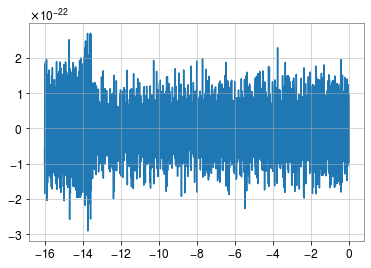

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
#plt.plot(interferometers[0].frequency_array[500:2500], interferometers[0].whitened_frequency_domain_strain[500:2500])
plt.plot(interferometers[0].time_array, interferometers[0].time_domain_strain)

In [5]:
interferometers[0].whitened_frequency_domain_strain.to_pycbc_frequencyseries()

AttributeError: 'numpy.ndarray' object has no attribute 'to_pycbc_frequencyseries'

In [31]:
interferometers

[Interferometer(name='H1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/home/alapel/.local/lib/python3.6/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=1024.0, length=4.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.9994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05),
 Interferometer(name='L1', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='/home/alapel/.local/lib/python3.6/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), minimum_frequency=20.0, maximum_frequency=1024.0, length=4.0, latitude=30.562894333333332, longitude=-90.77424038888887, elevation=-6.574, xarm_azimuth=197.7165, yarm_azimuth=287.7165, xarm_tilt=0.0, yarm_tilt=0.0),
 Interferometer(name='V1', power_spectral_density=PowerSpectralDensity(psd_file='/home/alapel/.local/lib/python3.6/site-packages/bilby/gw/detector/noise

In [33]:
4*42

168